In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../util/')
import feedforward_robust as ffr
import ipdb
from mnist_corruption import *
from util import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

W0920 10:16:41.759418 4392146368 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [4]:
x_train_flat.shape

(60000, 784)

In [5]:
def plot_singular_values(matrix, idx, title):
    _, sig, V = np.linalg.svd(matrix)
    plt.plot(range(len(sig)), sig, label = "Layer number %d" %idx)
    plt.legend(loc = 'upper right')
    plt.title(title)
    return sig

In [6]:
def regular_training(config_inp):
    eps_train = config_inp['eps_train'] 
    eps_test = config_inp['eps_test'] 
    tensorboard_dir = config_inp['tensorboard_dir'] 
    weights_dir = config_inp['weights_dir']
    load_counter = config_inp['load_counter'] 
    sigma = config_inp['sigma']
    scope_name = config_inp['scope_name']
    
    with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
        sess = tf.Session()
        logdir = tensorboard_dir + str(counter) + "/non_robust"

        #Create, train and test model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
        logger.info("Created model successfully. Now going to load weights")
        
        #Restore weights
        weights, biases = model.get_weights()
        weights_exp = weights + biases
        saver = tf.train.Saver(weights_exp)
        weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter) + ".ckpt")

        writer.add_graph(sess.graph)

        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))

        
        with tf.variable_scope("testing_benign") as scope:
            loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            logger.info("----Regular test accuracy and loss ----")
            logger.info((loss_reg, acc_reg))


        with tf.variable_scope("testing_adversarial") as scope:
            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            logger.info("----FGSM test accuracy and loss ----")
            logger.info((loss_fgsm, acc_fgsm))
            x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
    return model, sess

In [7]:
def hybrid_training(config_inp):
    eps_train = config_inp['eps_train'] 
    eps_test = config_inp['eps_test'] 
    tensorboard_dir = config_inp['tensorboard_dir'] 
    weights_dir = config_inp['weights_dir']
    load_counter_non_robust = config_inp['load_counter_non_robust'] 
    load_counter_robust = config_inp['load_counter_robust']
    sigma = config_inp['sigma']
    scope_name = config_inp['scope_name']
    should_slash = config_inp['should_slash']
    slash_factor = config_inp['slash_factor']
    
    with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
        sess = tf.Session()
        logdir = tensorboard_dir + str(counter)

        #Create, train and test model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma =sigma)
        feed_dict = {model.x: x_train_flat, model.y: y_train}
        sess.run(tf.global_variables_initializer(), feed_dict = feed_dict)
        logger.info("Created model successfully. Now going to load weights")
        
        #Restore all weights from non-robust
        weights, biases = model.get_weights()
        weights_exp = weights + biases
        saver = tf.train.Saver(weights_exp)
        weights_path = saver.restore(sess, weights_dir + "model_" + str(load_counter_non_robust) + ".ckpt")
        
        #Optionally slash weights
        if should_slash:
            model.slash_weights(sess, slash_factor)
            logger.info("Successfully slashed weights")
        
        logger.info("Successfully restored weights from non rob model.")

        #Restore the first and last layer from the robust model
        weights, biases = model.get_weights()
        selected_vars = [weights[0]] + [weights[-1]] + [biases[0]] + [biases[-1]]
        saver = tf.train.Saver(selected_vars)
        weights_path_rob = saver.restore(sess, weights_dir + "model_" + str(load_counter_robust) + ".ckpt")
        
        logger.info("Successfully restored weights from rob model.")
        
        #Run one epoch to try to make the weights more compatible with each other
        
        model.fit(sess, x_train_flat[0:10000], y_train[0:10000], training_epochs = 1, reg = 0, lr =3e-3)
        logger.info("Trained one epoch to attempt to make weights from different models compatible")
        
        #writer.add_graph(sess.graph)
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        logger.info("----Regular test accuracy and loss ----")
        logger.info((loss_reg, acc_reg))

        logger.info("Evaluating on FGSM points now.")
        loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
        logger.info("----FGSM test accuracy and loss ----")
        logger.info((loss_fgsm, acc_fgsm))
        x_test_flat_adv = model.fgsm_np(sess, x_test_flat, y_test, eps_test)
    
        logger.info("Evaluating on PGD points now.")
        loss_pgd, acc_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=1e-2, num_iter = 40)
        logger.info("----PGD test accuracy and loss ----")
        logger.info((loss_pgd , acc_pgd))
        
    return model, sess

In [8]:
def adversarial_training(config):
    eps_train = config['eps_train'] 
    eps_test = config['eps_test'] 
    tensorboard_dir = config['tensorboard_dir'] 
    weights_dir = config['weights_dir']
    load_counter = config['load_counter'] 
    sigma = config['sigma']
    scope_name_rob = config['scope_name']
    sess = tf.Session()
    hidden_sizes = [32,32,32,32,32,32,32]
    
    dataset = ((x_train_flat, y_train), (x_test_flat, y_test))

    with tf.variable_scope(scope_name_rob, reuse = tf.AUTO_REUSE) as scope:
        tmp = set(tf.all_variables())
        logdir = tensorboard_dir + str(counter) + "/robust"
        writer_robust = tf.summary.FileWriter(logdir)
        logger.info("Adversarial Training")
        robust_model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer_robust, scope = scope_name_rob, logger = logger, sigma = sigma)
        
        sess.run(tf.initialize_variables(set(tf.all_variables()) - tmp))
        robust_model.adv_fit(sess, x_train_flat, y_train, eps_train, lr = 3e-4, training_epochs = 20)

        print(robust_model.evaluate(sess, x_test_flat, y_test))
        print(robust_model.adv_evaluate(sess, x_test_flat, y_test, eps_test))
    return robust_model, sess

In [9]:
def activation_distance(activation_list):
    diff = []
    diff_norms = []
    for i in range(len(activation_list) - 1):
        difference = activation_list[i+1] - activation_list[i]
        diff.append(difference)
        diff_norms.append(np.linalg.norm(difference)/np.linalg.norm(activation_list[i]))
    return diff, diff_norms

In [10]:
def make_plot_acc_vs_eps_black_box(model_list, sess_list, eps_list, angle_list, legend_list, scope_list):
    x_test_2d = np.array([vec.reshape((28,28)) for vec in x_test_flat])
    fig = plt.figure(figsize = (10,10))
    ax_gb = fig.add_subplot(2, 2, 1)
    ax_rp = fig.add_subplot(2, 2, 2)
    ax_bw = fig.add_subplot(2, 2, 3)
    ax_rot = fig.add_subplot(2, 2, 4)
    
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        legend = legend_list[idx]
        gb_acc = []
        rp_acc = []
        bw_acc = []
        rot_acc = []
        
        scope_name = scope_list[idx]
        
        for (idx, eps_test) in enumerate(eps_list):
            x_test_gaussian_blurred = flatten_mnist(gaussian_blurring(x_test_2d, eps_test))[0]
            x_test_random_pert = flatten_mnist(random_perturbation(x_test_2d, eps_test))[0]
            x_test_black_white = flatten_mnist(random_blackout_whiteout(x_test_2d, eps_test))[0]
            angle = angle_list[idx]
            x_test_rot = flatten_mnist(rotate(x_test_2d, angle))[0]
            
            #ipdb.set_trace()
            gb_acc.append(model.evaluate(sess, x_test_gaussian_blurred, y_test)[1])
            rp_acc.append(model.evaluate(sess, x_test_random_pert, y_test)[1])
            bw_acc.append(model.evaluate(sess, x_test_black_white, y_test)[1])
            rot_acc.append(model.evaluate(sess, x_test_rot, y_test)[1])

        ax_gb.plot(eps_list, gb_acc, label = legend)
        ax_rp.plot(eps_list, rp_acc, label = legend)
        ax_bw.plot(eps_list, bw_acc, label = legend)
        ax_rot.plot(angle_list, rot_acc, label = legend)
 
    ax_gb.set_title("Gaussian blurring")
    ax_rp.set_title("Random perturbation")
    ax_bw.set_title("Blackwhite")
    ax_rot.set_title("Rotation")
    
    plt.legend(loc = (2.5, 0.7))
    plt.show()
    return True

In [11]:
def make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = False):
    fig = plt.figure()
    x_test_2d = [vec.reshape((28,28)) for vec in x_test_flat]
    
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        legend = legend_list[idx]
        y_array = []
        scope_name = scope_list[idx]
        
        for eps_test in eps_list:
            if not pgd:
                _, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
                y_array.append(acc_fgsm)
            else:
                with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
                    _, acc_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=1e-2, num_iter = 50)
                    y_array.append(acc_pgd)
                    
        plt.plot(eps_list, y_array, label = legend)
    
    plt.legend(loc = 1)
    plt.show()
    return True

In [12]:
def get_stats_all_models(model_list, sess_list, scope_list):
    
    eps_test = 0.1
    reg_evals = []
    adv_evals = []
    margins = []
    dphi_dxs = []
        
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        y_array = []
        scope_name = scope_list[idx]

        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
            #Get dphi_dx
            dphi_dx_test = model.get_dphi_dx(sess, x_test_flat)[0]
            dphi_dxs.append(np.mean(np.abs(dphi_dx_test)))
            
            #Get reg_evals
            reg_evals.append(model.evaluate(sess, x_test_flat, y_test))
            
            #Get adv_evals
            adv_evals.append(model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False))
            
            #Get margins
            x_test_feat_pert = model.attack_featurization_space(sess, x_test_flat, y_test, 1.0, 0.1, 200)
            loss_feat_adv, acc_feat_adv = model.evaluate_from_featurizations(sess, x_test_feat_pert, y_test)
            margins.append(acc_feat_adv)
            
    return reg_evals, adv_evals, margins, dphi_dxs

In [13]:
def make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order):
    plt.figure()
    
    for idx, model in enumerate(model_list):
        sess = sess_list[idx]
        scope_name = scope_list[idx]
        legend = legend_list[idx]

        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:
            y_array = model.get_distance(sess, 0.10, x_test_flat, y_test, order = order)[0]
            plt.plot(range(len(y_array)), y_array, label = legend)
    
    plt.legend()
    plt.show()
    return True

In [14]:
scope_list = ["hybrid", "model_non_robust", ]

In [15]:
x_test_2d = [vec.reshape((28,28)) for vec in x_test_flat]

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


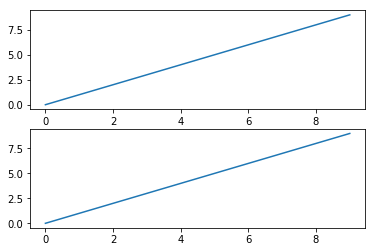

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


ax1.plot(range(10), range(10))
ax2.plot(range(10), range(10))

fig.show()

### Trying out different corruptions 

In [17]:
#Random trying out stuff
x_test_gaussian_blurred = gaussian_blurring(x_test_2d, 0.5)

In [18]:
x_test_rotated = rotate(x_test_2d, angle = 45)

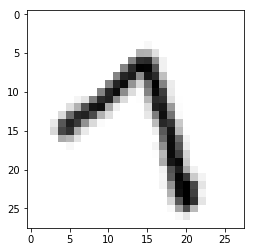

In [19]:
plt.imshow(x_test_rotated[0], cmap = plt.cm.binary)

# Hybrid Training

In [20]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter_robust'] = 280
config['load_counter_non_robust'] = 282
config['should_slash'] = False
config['slash_factor'] = 0.70

config['sigma'] = tf.nn.relu

config['scope_name'] = "hybrid"

In [21]:
model_hybrid, sess_hybrid = hybrid_training(config)

Initialized instance variables of the robust model class
I0920 10:16:45.993755 4392146368 feedforward_robust.py:30] Initialized instance variables of the robust model class
W0920 10:16:45.995215 4392146368 deprecation_wrapper.py:119] From ../feedforward_robust.py:34: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0920 10:16:45.998034 4392146368 feedforward_robust.py:36] Created placeholders for x and y
W0920 10:16:45.999257 4392146368 deprecation_wrapper.py:119] From ../util.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0920 10:16:46.000660 4392146368 deprecation_wrapper.py:119] From ../util.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0920 10:16:46.002074 4392146368 deprecation_wrapper.py:119] From ../util.py:36: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0920 10:16:46.095

iteration: 0
loss 0.787131
iteration: 1
loss 0.962737
iteration: 2
loss 1.150967
iteration: 3
loss 1.345097
iteration: 4
loss 1.548232
iteration: 5
loss 1.748961
iteration: 6
loss 1.949145
iteration: 7
loss 2.145091
iteration: 8
loss 2.334656
iteration: 9
loss 2.514583
iteration: 10
loss 2.686329
iteration: 11
loss 2.847018
iteration: 12
loss 2.999974
iteration: 13
loss 3.139104
iteration: 14
loss 3.270664
iteration: 15
loss 3.386484
iteration: 16
loss 3.489648
iteration: 17
loss 3.580036
iteration: 18
loss 3.652444
iteration: 19
loss 3.713259
iteration: 20
loss 3.762960
iteration: 21
loss 3.808323
iteration: 22
loss 3.850324
iteration: 23
loss 3.886114
iteration: 24
loss 3.919606
iteration: 25
loss 3.948111
iteration: 26
loss 3.975431
iteration: 27
loss 3.997395
iteration: 28
loss 4.020524
iteration: 29
loss 4.037024
iteration: 30
loss 4.056332
iteration: 31
loss 4.069665
iteration: 32
loss 4.083243
iteration: 33
loss 4.094179
iteration: 34
loss 4.106165
iteration: 35
loss 4.116448
it

This is to confirm that attack does not violate constraints
I0920 10:16:52.463804 4392146368 feedforward_robust.py:209] This is to confirm that attack does not violate constraints
Should be no more than eps
I0920 10:16:52.465035 4392146368 feedforward_robust.py:210] Should be no more than eps


loss 4.142182
iteration: 39
loss 4.149288


0.10000005352730845
I0920 10:16:52.522832 4392146368 feedforward_robust.py:211] 0.10000005352730845
----PGD test accuracy and loss ----
I0920 10:16:52.543544 4392146368 <ipython-input-7-ee235a87947b>:63] ----PGD test accuracy and loss ----
(4.1492877, 0.2103)
I0920 10:16:52.546255 4392146368 <ipython-input-7-ee235a87947b>:64] (4.1492877, 0.2103)


In [22]:
dphi_dx_test_hybrid = model_hybrid.get_dphi_dx(sess_hybrid, x_test_flat)[0]

In [23]:
np.mean(np.abs(dphi_dx_test_hybrid))

0.39415258

In [24]:
dpred_dx_test_hybrid = model_hybrid.get_pred_dx(sess_hybrid, x_test_flat)[0]
np.mean(np.abs(dpred_dx_test_hybrid))

0.92792237

## Regular Training

In [25]:
#tf.reset_default_graph()

In [26]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 222
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [27]:
config['scope_name']

'model_non_robust'

In [28]:
model_non_robust, sess_non_robust = regular_training(config)

Initialized instance variables of the robust model class
I0920 10:16:53.308425 4392146368 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:16:53.312787 4392146368 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:16:53.462641 4392146368 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:16:53.483273 4392146368 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:16:53.488976 4392146368 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:16:53.491852 4392146368 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0920 10:16:53.495589 4392146368 <ipython-input-6-cc1dd069280b>:17] Created model successfully. Now going to load weights
Model was evalua

In [29]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_non_robust = model_non_robust.get_weights_np(sess_non_robust)

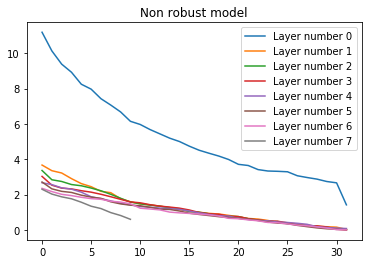

In [30]:
#Original without regularization
sing_vals = []
for (idx, weight_matrix) in enumerate(weights_non_robust):
        sig = plot_singular_values(weight_matrix, idx, "Non robust model")
        sing_vals.append(sig)

In [31]:
#Regular points
acts = model_non_robust.get_activation(sess_non_robust, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, config['eps_test'])
acts_adv = model_non_robust.get_activation(sess_non_robust, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [32]:
diff_norm

[1.2221951, 1.2958775, 1.2866542, 1.2522035, 1.2535323, 1.1977569]

In [33]:
diff_norm_adv

[1.1699435, 1.2277226, 1.1832038, 1.2514116, 1.2267895, 1.1607223]

In [34]:
dphi_dx_test = model_non_robust.get_dphi_dx(sess_non_robust, x_test_flat)[0]

In [35]:
dphi_dx_test[0]

array([ 2.57825583e-01,  8.78084004e-02, -7.54263550e-02,  1.16312869e-01,
       -1.05404118e-02,  5.11546850e-01,  1.08980112e-01,  3.60112667e-01,
       -1.30970672e-01,  2.86065906e-01, -2.51386076e-01, -5.32598734e-01,
       -9.00848925e-01, -8.47756684e-01, -4.31117505e-01, -1.08172905e+00,
        3.92692178e-01, -1.76614270e-01, -1.28510660e-02, -8.11763108e-02,
       -3.29416454e-01, -9.48862731e-02, -1.95206463e-01, -9.28842127e-02,
       -5.44355273e-01,  2.50157624e-01,  1.45502254e-01, -1.56610504e-01,
       -2.50830531e-01, -2.74944484e-01, -3.48501772e-01, -3.18996042e-01,
        2.88076341e-01, -3.94406408e-01, -1.00904870e+00, -9.62924361e-01,
       -3.92116129e-01, -6.67419016e-01, -1.37607694e+00, -5.23529112e-01,
       -1.57230663e+00, -1.94908154e+00, -4.86297607e-01, -5.91748834e-01,
       -5.78102291e-01, -1.01870322e+00, -1.40130401e+00, -1.06577003e+00,
       -1.01430583e+00, -1.43360734e+00, -1.34260607e+00, -1.00455070e+00,
        4.18147981e-01, -

In [36]:
dphi_dx_test_non_robust = dphi_dx_test
np.mean(np.abs(dphi_dx_test_non_robust))

0.8664375

In [37]:
dpred_dx_test_non_robust = model_non_robust.get_pred_dx(sess_non_robust, x_test_flat)[0]
np.mean(np.abs(dpred_dx_test_non_robust))

0.59841245

In [38]:
with tf.variable_scope(config['scope_name'], reuse = tf.AUTO_REUSE) as scope:
    x_test_feat_pert = model_non_robust.attack_featurization_space(sess_non_robust, x_test_flat, y_test, 1.0, 0.1, 200)
    loss_feat_adv, acc_feat_adv = model_non_robust.evaluate_from_featurizations(sess_non_robust, x_test_feat_pert, y_test)
    print(loss_feat_adv, acc_feat_adv)

Obtained featurizations
I0920 10:16:55.901289 4392146368 feedforward_robust.py:216] Obtained featurizations
W0920 10:16:55.909543 4392146368 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:2618: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Created feat adv graph
I0920 10:16:56.194298 4392146368 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.255426
iteration: 1
loss 0.330864
iteration: 2
loss 0.421122
iteration: 3
loss 0.527056
iteration: 4
loss 0.648912
iteration: 5
loss 0.785834
iteration: 6
loss 0.935952
iteration: 7
loss 1.096786
iteration: 8
loss 1.264967
iteration: 9
loss 1.436727
iteration: 10
loss 1.607869
iteration: 11
loss 1.773870
iteration: 12
loss 1.930376
iteration: 13
loss 2.074139
iteration: 14
loss 2.202028
iteration: 15
loss 2.311141
iteration: 16
loss 2.399636
iteration: 17
loss 2.465578
iteration: 18
loss 2.507631
iteration: 19
loss 2.525578
iteration: 20
loss 2.531332
iteration: 21
loss 2.536743
iteration: 22
loss 2.541804
iteration: 23
loss 2.546511
iteration: 24
loss 2.550928
iteration: 25
loss 2.555027
iteration: 26
loss 2.558769
iteration: 27
loss 2.562219
iteration: 28
loss 2.565414
iteration: 29
loss 2.568331
iteration: 30
loss 2.571009
iteration: 31
loss 2.573480
iteration: 32
loss 2.575694
iteration: 33
loss 2.577690
iteration: 34
loss 2.579464
iteration: 35
loss 2.581026
it

Found adversarial featurizations
I0920 10:16:57.626334 4392146368 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:16:57.649785 4392146368 feedforward_robust.py:383] Model was evaluated from featurizations


loss 2.595721
iteration: 191
loss 2.595721
iteration: 192
loss 2.595721
iteration: 193
loss 2.595721
iteration: 194
loss 2.595721
iteration: 195
loss 2.595721
iteration: 196
loss 2.595721
iteration: 197
loss 2.595721
iteration: 198
loss 2.595721
iteration: 199
loss 2.595721
2.595721 0.3249


In [39]:
adv_images_fgsm = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, 0.10)

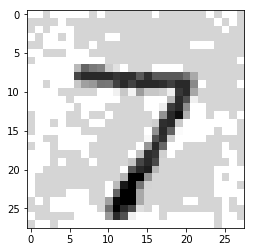

In [40]:
test_image = adv_images_fgsm[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [41]:
"""
test_image = adv_images_pgd[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)
"""

'\ntest_image = adv_images_pgd[0]\ntwo_d = test_image.reshape((28,28))\nplt.imshow(two_d, cmap = plt.cm.binary)\n'

## Op norm Regularization

In [42]:
#Config
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 354
config['sigma'] = tf.nn.relu

config['scope_name'] = "hybrid"

In [43]:
config['scope_name']

'hybrid'

In [44]:
op_model, sess_op = regular_training(config)

Initialized instance variables of the robust model class
I0920 10:16:58.501794 4392146368 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:16:58.504873 4392146368 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:16:58.549507 4392146368 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:16:58.577023 4392146368 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:16:58.587984 4392146368 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:16:58.591013 4392146368 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0920 10:16:58.597859 4392146368 <ipython-input-6-cc1dd069280b>:17] Created model successfully. Now going to load weights
Model was evalua

## L1 Reg

In [45]:
#Config
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 331
config['sigma'] = tf.nn.relu

config['scope_name'] = "hybrid"
config['scope_name']
l1_model, sess_l1 = regular_training(config)

Initialized instance variables of the robust model class
I0920 10:16:59.567459 4392146368 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:16:59.570765 4392146368 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:16:59.608049 4392146368 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:16:59.644883 4392146368 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:16:59.651885 4392146368 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:16:59.654897 4392146368 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0920 10:16:59.660444 4392146368 <ipython-input-6-cc1dd069280b>:17] Created model successfully. Now going to load weights
Model was evalua

## Trace regularization for first layer

In [46]:
#Config
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 121
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [47]:
config['scope_name']

'model_non_robust'

In [48]:
reg_model, sess_reg = regular_training(config)

Initialized instance variables of the robust model class
I0920 10:17:00.819647 4392146368 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:17:00.826623 4392146368 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:17:00.903466 4392146368 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:17:00.936314 4392146368 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:17:00.946191 4392146368 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:17:00.951689 4392146368 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0920 10:17:00.956701 4392146368 <ipython-input-6-cc1dd069280b>:17] Created model successfully. Now going to load weights
Model was evalua

In [49]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = reg_model.get_weights_np(sess_reg)

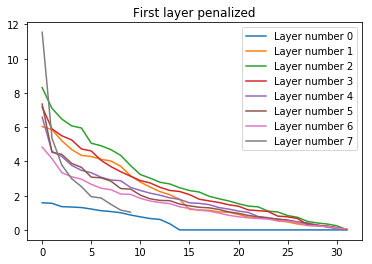

In [50]:
#With regularization
sing_vals_reg = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx, "First layer penalized")
        sing_vals_reg.append(sig)

**Interpretation** This is pretty interesting. When you penalize the singular values of the first layer, all the other layers start increasing to compensate - I'm guessing to keep the expressiveness high. Probably, if we penalize all the singular values, it may not learn anything?

So we still have not suceeded at replicating the singular value spectrum of the robust model - so it is difficult to conclude whether the singular value spectrum is a determinant of adversarial robustness or not

In [51]:
#With regularization - first layer
sing_vals_reg

[array([1.5870155e+00, 1.5522803e+00, 1.3584403e+00, 1.3370733e+00,
        1.3070780e+00, 1.2188531e+00, 1.1234620e+00, 1.0728732e+00,
        1.0041257e+00, 8.7067133e-01, 7.6290888e-01, 6.6413921e-01,
        6.1234343e-01, 3.5728675e-01, 6.2625506e-04, 4.9098406e-04,
        4.8556362e-04, 4.5167084e-04, 3.1356234e-04, 3.0216103e-04,
        2.7841594e-04, 2.0602574e-04, 1.9646439e-04, 1.8619838e-04,
        1.4287693e-04, 1.3560396e-04, 1.2213681e-04, 3.9542541e-05,
        3.5572761e-05, 1.7289583e-05, 8.5304418e-06, 5.9684144e-06],
       dtype=float32),
 array([6.035554  , 5.8620715 , 5.20899   , 4.6957164 , 4.3550816 ,
        4.287016  , 4.125534  , 4.0239434 , 3.7177262 , 3.1656983 ,
        2.7954736 , 2.499863  , 2.23836   , 2.055546  , 1.7796141 ,
        1.2052387 , 1.1660684 , 1.1480169 , 1.0525272 , 1.0315014 ,
        0.90306103, 0.74932116, 0.6895752 , 0.6741662 , 0.5238548 ,
        0.469349  , 0.34676093, 0.27730793, 0.22861174, 0.21915486,
        0.12821923, 0.04

In [52]:
#Regular points
acts = reg_model.get_activation(sess_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = reg_model.fgsm_np(sess_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = reg_model.get_activation(sess_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [53]:
diff_norm

[1.6056864, 1.8563683, 1.5560254, 1.3894248, 1.1853814, 1.2059872]

In [54]:
diff_norm_adv

[1.5158699, 1.7118087, 1.3908907, 1.3478867, 1.1872182, 1.2078623]

In [55]:
dphi_dx_robust_first_reg = reg_model.get_dphi_dx(sess_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_first_reg))

0.29407898

In [56]:
dpred_dx_robust_first_reg = reg_model.get_pred_dx(sess_reg, x_test_flat)
np.mean(np.abs(dpred_dx_robust_first_reg))

0.53012115

# Trace regularization for all layers

In [57]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 126
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_non_robust"

In [58]:
model_all_reg, sess_all_reg = regular_training(config)

Initialized instance variables of the robust model class
I0920 10:17:03.721007 4392146368 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:17:03.724092 4392146368 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:17:03.774635 4392146368 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:17:03.803282 4392146368 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:17:03.812487 4392146368 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:17:03.815452 4392146368 feedforward_robust.py:52] Model graph was created
Created model successfully. Now going to load weights
I0920 10:17:03.819991 4392146368 <ipython-input-6-cc1dd069280b>:17] Created model successfully. Now going to load weights
Model was evalua

In [59]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = model_all_reg.get_weights_np(sess_all_reg)

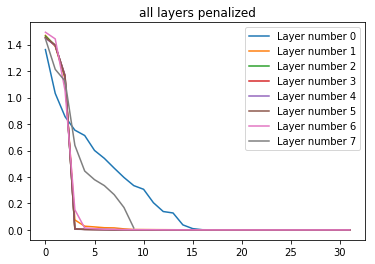

In [60]:
#With regularization
sing_vals_all = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx, "all layers penalized")
        sing_vals_all.append(sig)

In [61]:
#Regular points
acts = model_all_reg.get_activation(sess_all_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_all_reg.fgsm_np(sess_all_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = model_all_reg.get_activation(sess_all_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [62]:
diff_norm

[1.2381881, 1.1723968, 0.9998556, 1.2088721, 1.156904, 1.2247998]

In [63]:
diff_norm_adv

[1.2208154, 1.1831144, 1.000097, 1.2062595, 1.1468935, 1.2146919]

In [64]:
dphi_dx_robust_all_reg = reg_model.get_dphi_dx(sess_all_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_all_reg))

0.20034555

In [65]:
dpred_dx_robust_all_reg = reg_model.get_pred_dx(sess_all_reg, x_test_flat)
np.mean(np.abs(dpred_dx_robust_all_reg))

0.0020152025

# FGSM Adversarial Training

In [66]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 280
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_robust"

In [67]:
model_rob, sess_rob = adversarial_training(config)

Adversarial Training
I0920 10:17:07.091988 4392146368 <ipython-input-8-d7d1c01af8cd>:18] Adversarial Training
Initialized instance variables of the robust model class
I0920 10:17:07.093357 4392146368 feedforward_robust.py:30] Initialized instance variables of the robust model class
Created placeholders for x and y
I0920 10:17:07.096680 4392146368 feedforward_robust.py:36] Created placeholders for x and y
Created layers and tensor for logits
I0920 10:17:07.255461 4392146368 feedforward_robust.py:40] Created layers and tensor for logits
Added loss computation to the graph
I0920 10:17:07.277691 4392146368 feedforward_robust.py:45] Added loss computation to the graph
Added accuracy computation to the graph
I0920 10:17:07.284822 4392146368 feedforward_robust.py:49] Added accuracy computation to the graph
Model graph was created
I0920 10:17:07.288209 4392146368 feedforward_robust.py:52] Model graph was created
Epoch: 0001    cost: 1.643306008 
I0920 10:17:13.003680 4392146368 feedforward_rob

(0.4612001, 0.841)


Model is being evaluated on FGSM data
I0920 10:18:20.593106 4392146368 feedforward_robust.py:363] Model is being evaluated on FGSM data


(0.48272133, 0.8478)


In [68]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_robust = model_rob.get_weights_np(sess_rob)

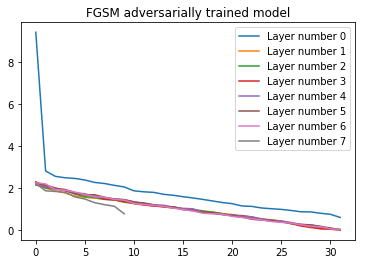

In [69]:
sing_vals_robust = []
for (idx, weight_matrix) in enumerate(weights_robust):
    sig = plot_singular_values(weight_matrix, idx, "FGSM adversarially trained model")
    sing_vals_robust.append(sig)

In [70]:
dphi_dx_robust = model_rob.get_dphi_dx(sess_rob, x_test_flat)
np.mean(np.abs(dphi_dx_robust))

0.42212602

In [71]:
dpred_dx_robust = model_rob.get_pred_dx(sess_rob, x_test_flat)
np.mean(np.abs(dpred_dx_robust))

0.14948206

In [72]:
sing_vals[0]

array([11.189289 , 10.133197 ,  9.383851 ,  8.92445  ,  8.247922 ,
        7.969636 ,  7.4290295,  7.0685034,  6.6811824,  6.1500745,
        5.970582 ,  5.6832013,  5.439685 ,  5.1961956,  5.0047846,
        4.7424994,  4.5128593,  4.3439555,  4.1835628,  3.9895031,
        3.7153032,  3.6492496,  3.417802 ,  3.3370526,  3.3204548,
        3.294197 ,  3.0694237,  2.9688969,  2.8788092,  2.7434793,
        2.6681807,  1.4231784], dtype=float32)

In [73]:
sing_vals_robust[0]

array([9.402371  , 2.8063126 , 2.5497608 , 2.4828649 , 2.4515615 ,
       2.3774502 , 2.2622333 , 2.2102532 , 2.1228075 , 2.0477335 ,
       1.863367  , 1.8160318 , 1.7897426 , 1.6977935 , 1.6507922 ,
       1.5839972 , 1.5243194 , 1.4553534 , 1.3809303 , 1.3069934 ,
       1.252165  , 1.1429838 , 1.1231241 , 1.0467855 , 1.0119342 ,
       0.98106617, 0.9295715 , 0.86621016, 0.86113834, 0.79650646,
       0.74776006, 0.5988879 ], dtype=float32)

In [74]:
sing_vals[1]

array([3.674316  , 3.3551764 , 3.224709  , 2.9054708 , 2.6243584 ,
       2.4510684 , 2.1869967 , 2.1103704 , 1.7720344 , 1.5988731 ,
       1.4801615 , 1.421275  , 1.3496728 , 1.2716495 , 1.1624023 ,
       1.0521415 , 1.0061094 , 0.94067425, 0.904368  , 0.82833225,
       0.75014293, 0.6533072 , 0.61833286, 0.5395455 , 0.42479357,
       0.39901435, 0.33884445, 0.26813343, 0.20976494, 0.18486662,
       0.15978248, 0.03111679], dtype=float32)

In [75]:
sing_vals_robust[1]

array([2.2732074 , 1.9831287 , 1.8669405 , 1.755076  , 1.6206328 ,
       1.5542196 , 1.5124592 , 1.4662458 , 1.4320173 , 1.3178259 ,
       1.2596756 , 1.2053299 , 1.159635  , 1.0974995 , 1.0401777 ,
       1.0051836 , 0.940749  , 0.8824709 , 0.8512473 , 0.77801514,
       0.7352805 , 0.62514406, 0.58637553, 0.52273804, 0.487492  ,
       0.4228845 , 0.35181078, 0.21080692, 0.16935487, 0.05641804,
       0.04673804, 0.01566951], dtype=float32)

In [76]:
sing_vals[2]

array([3.3668115 , 2.842233  , 2.7448304 , 2.5716846 , 2.5023568 ,
       2.3724024 , 2.2186227 , 2.019235  , 1.795118  , 1.5796243 ,
       1.4817913 , 1.4066254 , 1.3463677 , 1.25288   , 1.2033571 ,
       1.0469009 , 1.0039477 , 0.91686976, 0.8075825 , 0.76937425,
       0.758841  , 0.63528323, 0.55939764, 0.49177903, 0.47970247,
       0.3502487 , 0.29832286, 0.24977762, 0.20475344, 0.14861573,
       0.07453168, 0.01873747], dtype=float32)

In [77]:
sing_vals_robust[2]

array([2.1488266 , 1.9939443 , 1.9522287 , 1.8813233 , 1.7150629 ,
       1.5835944 , 1.5487231 , 1.452834  , 1.4375583 , 1.3327538 ,
       1.2828424 , 1.2541214 , 1.1943456 , 1.1108713 , 1.0560832 ,
       1.0056821 , 0.98221636, 0.910012  , 0.8508382 , 0.78233004,
       0.6666749 , 0.61281115, 0.5558815 , 0.50155926, 0.4651679 ,
       0.4060139 , 0.30360776, 0.24127711, 0.17925891, 0.13751337,
       0.07038508, 0.03128624], dtype=float32)

In [78]:
sing_vals[-1]

array([2.3056653 , 2.0326595 , 1.8763782 , 1.7655128 , 1.5709738 ,
       1.3455315 , 1.2124654 , 0.9837641 , 0.81992024, 0.6042539 ],
      dtype=float32)

In [79]:
sing_vals_robust[-1]

array([2.207943  , 1.8645161 , 1.831318  , 1.7925018 , 1.5701457 ,
       1.4729532 , 1.2998121 , 1.2046202 , 1.1295799 , 0.77293843],
      dtype=float32)

In [80]:
#Regular points
acts = model_rob.get_activation(sess_rob, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_rob.fgsm_np(sess_rob, x_test_flat, y_test, config['eps_test'])
acts_adv = model_rob.get_activation(sess_rob, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [81]:
diff_norm

[1.0212289, 1.0397582, 0.9133326, 1.0382593, 1.0916231, 1.0749552]

In [82]:
diff_norm_adv

[1.0390023, 1.0062617, 0.9433606, 1.0347182, 1.1180093, 1.0279893]

# Comparison plots

## Distances

In [83]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

Getting activation distances between regular and FGSM data
I0920 10:18:23.143635 4392146368 feedforward_robust.py:309] Getting activation distances between regular and FGSM data
Found correct and incorrect indices
I0920 10:18:23.562162 4392146368 feedforward_robust.py:314] Found correct and incorrect indices
Found average and standard deviation of distances
I0920 10:18:32.878566 4392146368 feedforward_robust.py:329] Found average and standard deviation of distances
Found average and standard deviation of distances
I0920 10:18:33.417993 4392146368 feedforward_robust.py:329] Found average and standard deviation of distances
Found average and standard deviation of distances
I0920 10:18:41.789392 4392146368 feedforward_robust.py:329] Found average and standard deviation of distances
Getting activation distances between regular and FGSM data
I0920 10:18:41.828614 4392146368 feedforward_robust.py:309] Getting activation distances between regular and FGSM data
Found correct and incorrect indi

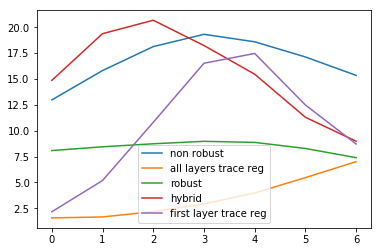

True

In [84]:
make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = 2)

Getting activation distances between regular and FGSM data
I0920 10:19:57.708436 4392146368 feedforward_robust.py:309] Getting activation distances between regular and FGSM data
Found correct and incorrect indices
I0920 10:19:58.096936 4392146368 feedforward_robust.py:314] Found correct and incorrect indices
Found average and standard deviation of distances
I0920 10:20:07.470960 4392146368 feedforward_robust.py:329] Found average and standard deviation of distances
Found average and standard deviation of distances
I0920 10:20:08.029192 4392146368 feedforward_robust.py:329] Found average and standard deviation of distances
Found average and standard deviation of distances
I0920 10:20:17.871366 4392146368 feedforward_robust.py:329] Found average and standard deviation of distances
Getting activation distances between regular and FGSM data
I0920 10:20:17.916563 4392146368 feedforward_robust.py:309] Getting activation distances between regular and FGSM data
Found correct and incorrect indi

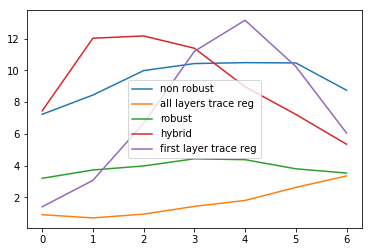

True

In [85]:
make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = float("inf"))

## Stats

In [86]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model, op_model, l1_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg, sess_op, sess_l1]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust",  "hybrid", "hybrid"]

In [87]:
reg_evals, adv_evals, margins, dphi_dxs = get_stats_all_models(model_list, sess_list, scope_list)

Model was evaluated on benign data
I0920 10:22:10.619015 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:22:10.947392 4392146368 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:22:10.981982 4392146368 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:22:11.188064 4392146368 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.256599
iteration: 1
loss 0.332823
iteration: 2
loss 0.423769
iteration: 3
loss 0.530448
iteration: 4
loss 0.653021
iteration: 5
loss 0.790237
iteration: 6
loss 0.940578
iteration: 7
loss 1.101467
iteration: 8
loss 1.269507
iteration: 9
loss 1.440617
iteration: 10
loss 1.610849
iteration: 11
loss 1.775909
iteration: 12
loss 1.931912
iteration: 13
loss 2.075248
iteration: 14
loss 2.202583
iteration: 15
loss 2.311172
iteration: 16
loss 2.399346
iteration: 17
loss 2.464949
iteration: 18
loss 2.507016
iteration: 19
loss 2.525044
iteration: 20
loss 2.530664
iteration: 21
loss 2.535918
iteration: 22
loss 2.540825
iteration: 23
loss 2.545397
iteration: 24
loss 2.549629
iteration: 25
loss 2.553575
iteration: 26
loss 2.557209
iteration: 27
loss 2.560550
iteration: 28
loss 2.563653
iteration: 29
loss 2.566501
iteration: 30
loss 2.569147
iteration: 31
loss 2.571525
iteration: 32
loss 2.573675
iteration: 33
loss 2.575644
iteration: 34
loss 2.577426
iteration: 35
loss 2.579034
it

Found adversarial featurizations
I0920 10:22:12.613196 4392146368 feedforward_robust.py:219] Found adversarial featurizations


loss 2.594202
iteration: 168
loss 2.594202
iteration: 169
loss 2.594202
iteration: 170
loss 2.594202
iteration: 171
loss 2.594202
iteration: 172
loss 2.594202
iteration: 173
loss 2.594202
iteration: 174
loss 2.594202
iteration: 175
loss 2.594202
iteration: 176
loss 2.594202
iteration: 177
loss 2.594202
iteration: 178
loss 2.594202
iteration: 179
loss 2.594202
iteration: 180
loss 2.594202
iteration: 181
loss 2.594202
iteration: 182
loss 2.594202
iteration: 183
loss 2.594202
iteration: 184
loss 2.594202
iteration: 185
loss 2.594202
iteration: 186
loss 2.594202
iteration: 187
loss 2.594202
iteration: 188
loss 2.594202
iteration: 189
loss 2.594202
iteration: 190
loss 2.594202
iteration: 191
loss 2.594202
iteration: 192
loss 2.594202
iteration: 193
loss 2.594202
iteration: 194
loss 2.594202
iteration: 195
loss 2.594202
iteration: 196
loss 2.594202
iteration: 197
loss 2.594202
iteration: 198
loss 2.594202
iteration: 199
loss 2.594202


Model was evaluated from featurizations
I0920 10:22:12.617356 4392146368 feedforward_robust.py:383] Model was evaluated from featurizations
Model was evaluated on benign data
I0920 10:22:12.964146 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:22:13.305279 4392146368 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:22:13.433154 4392146368 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:22:13.596144 4392146368 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.579895
iteration: 1
loss 0.668565
iteration: 2
loss 0.762228
iteration: 3
loss 0.859748
iteration: 4
loss 0.960029
iteration: 5
loss 1.061698
iteration: 6
loss 1.163237
iteration: 7
loss 1.263253
iteration: 8
loss 1.360534
iteration: 9
loss 1.453891
iteration: 10
loss 1.542045
iteration: 11
loss 1.624071
iteration: 12
loss 1.698849
iteration: 13
loss 1.765438
iteration: 14
loss 1.823239
iteration: 15
loss 1.871619
iteration: 16
loss 1.910275
iteration: 17
loss 1.938752
iteration: 18
loss 1.956720
iteration: 19
loss 1.963905
iteration: 20
loss 1.965612
iteration: 21
loss 1.967264
iteration: 22
loss 1.968851
iteration: 23
loss 1.970368
iteration: 24
loss 1.971799
iteration: 25
loss 1.973143
iteration: 26
loss 1.974395
iteration: 27
loss 1.975565
iteration: 28
loss 1.976647
iteration: 29
loss 1.977620
iteration: 30
loss 1.978502
iteration: 31
loss 1.979305
iteration: 32
loss 1.980018
iteration: 33
loss 1.980641
iteration: 34
loss 1.981191
iteration: 35
loss 1.981676
it

Found adversarial featurizations
I0920 10:22:14.943997 4392146368 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:22:14.987994 4392146368 feedforward_robust.py:383] Model was evaluated from featurizations


loss 1.985719
iteration: 183
loss 1.985719
iteration: 184
loss 1.985719
iteration: 185
loss 1.985719
iteration: 186
loss 1.985719
iteration: 187
loss 1.985719
iteration: 188
loss 1.985719
iteration: 189
loss 1.985719
iteration: 190
loss 1.985719
iteration: 191
loss 1.985719
iteration: 192
loss 1.985719
iteration: 193
loss 1.985719
iteration: 194
loss 1.985719
iteration: 195
loss 1.985719
iteration: 196
loss 1.985719
iteration: 197
loss 1.985719
iteration: 198
loss 1.985719
iteration: 199
loss 1.985719


Model was evaluated on benign data
I0920 10:22:15.344389 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:22:15.940313 4392146368 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:22:16.075237 4392146368 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:22:16.236664 4392146368 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.876102
iteration: 1
loss 1.245061
iteration: 2
loss 1.678389
iteration: 3
loss 2.162211
iteration: 4
loss 2.679207
iteration: 5
loss 3.212259
iteration: 6
loss 3.745269
iteration: 7
loss 4.264997
iteration: 8
loss 4.761409
iteration: 9
loss 5.227249
iteration: 10
loss 5.657376
iteration: 11
loss 6.048088
iteration: 12
loss 6.396638
iteration: 13
loss 6.701992
iteration: 14
loss 6.963436
iteration: 15
loss 7.181027
iteration: 16
loss 7.353401
iteration: 17
loss 7.479929
iteration: 18
loss 7.560915
iteration: 19
loss 7.596956
iteration: 20
loss 7.610431
iteration: 21
loss 7.623186
iteration: 22
loss 7.635164
iteration: 23
loss 7.646365
iteration: 24
loss 7.656888
iteration: 25
loss 7.666669
iteration: 26
loss 7.675658
iteration: 27
loss 7.683891
iteration: 28
loss 7.691433
iteration: 29
loss 7.698266
iteration: 30
loss 7.704387
iteration: 31
loss 7.709894
iteration: 32
loss 7.714869
iteration: 33
loss 7.719347
iteration: 34
loss 7.723380
iteration: 35
loss 7.726960
it

Found adversarial featurizations
I0920 10:22:17.581797 4392146368 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:22:17.631781 4392146368 feedforward_robust.py:383] Model was evaluated from featurizations


loss 7.758258
iteration: 185
loss 7.758258
iteration: 186
loss 7.758258
iteration: 187
loss 7.758258
iteration: 188
loss 7.758258
iteration: 189
loss 7.758258
iteration: 190
loss 7.758258
iteration: 191
loss 7.758258
iteration: 192
loss 7.758258
iteration: 193
loss 7.758258
iteration: 194
loss 7.758258
iteration: 195
loss 7.758258
iteration: 196
loss 7.758258
iteration: 197
loss 7.758258
iteration: 198
loss 7.758258
iteration: 199
loss 7.758258


Model was evaluated on benign data
I0920 10:22:18.030810 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:22:18.443173 4392146368 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:22:18.585283 4392146368 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:22:18.758777 4392146368 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 1.354598
iteration: 1
loss 1.943533
iteration: 2
loss 2.631864
iteration: 3
loss 3.387594
iteration: 4
loss 4.179908
iteration: 5
loss 4.978734
iteration: 6
loss 5.760895
iteration: 7
loss 6.510635
iteration: 8
loss 7.217258
iteration: 9
loss 7.873470
iteration: 10
loss 8.473320
iteration: 11
loss 9.013205
iteration: 12
loss 9.491871
iteration: 13
loss 9.908425
iteration: 14
loss 10.263340
iteration: 15
loss 10.557488
iteration: 16
loss 10.789969
iteration: 17
loss 10.962550
iteration: 18
loss 11.075960
iteration: 19
loss 11.129563
iteration: 20
loss 11.153850
iteration: 21
loss 11.176685
iteration: 22
loss 11.198092
iteration: 23
loss 11.218091
iteration: 24
loss 11.236770
iteration: 25
loss 11.254311
iteration: 26
loss 11.270592
iteration: 27
loss 11.285633
iteration: 28
loss 11.299388
iteration: 29
loss 11.312036
iteration: 30
loss 11.323562
iteration: 31
loss 11.334023
iteration: 32
loss 11.343536
iteration: 33
loss 11.351989
iteration: 34
loss 11.359488
iteration

Found adversarial featurizations
I0920 10:22:20.208276 4392146368 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:22:20.258309 4392146368 feedforward_robust.py:383] Model was evaluated from featurizations
Model was evaluated on benign data
I0920 10:22:20.662827 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:22:21.084793 4392146368 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:22:21.238004 4392146368 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:22:21.416898 4392146368 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.904726
iteration: 1
loss 1.385714
iteration: 2
loss 1.990440
iteration: 3
loss 2.700972
iteration: 4
loss 3.489854
iteration: 5
loss 4.323051
iteration: 6
loss 5.169015
iteration: 7
loss 5.999392
iteration: 8
loss 6.793031
iteration: 9
loss 7.537382
iteration: 10
loss 8.223083
iteration: 11
loss 8.844580
iteration: 12
loss 9.397640
iteration: 13
loss 9.881589
iteration: 14
loss 10.295688
iteration: 15
loss 10.641093
iteration: 16
loss 10.918502
iteration: 17
loss 11.127431
iteration: 18
loss 11.269131
iteration: 19
loss 11.344442
iteration: 20
loss 11.385796
iteration: 21
loss 11.424711
iteration: 22
loss 11.461297
iteration: 23
loss 11.495612
iteration: 24
loss 11.527905
iteration: 25
loss 11.558222
iteration: 26
loss 11.586402
iteration: 27
loss 11.612817
iteration: 28
loss 11.637451
iteration: 29
loss 11.660196
iteration: 30
loss 11.681090
iteration: 31
loss 11.700059
iteration: 32
loss 11.717132
iteration: 33
loss 11.732315
iteration: 34
loss 11.745939
iteration

Found adversarial featurizations
I0920 10:22:22.858894 4392146368 feedforward_robust.py:219] Found adversarial featurizations


loss 11.839551
iteration: 175
loss 11.839551
iteration: 176
loss 11.839551
iteration: 177
loss 11.839551
iteration: 178
loss 11.839551
iteration: 179
loss 11.839551
iteration: 180
loss 11.839551
iteration: 181
loss 11.839551
iteration: 182
loss 11.839551
iteration: 183
loss 11.839551
iteration: 184
loss 11.839551
iteration: 185
loss 11.839551
iteration: 186
loss 11.839551
iteration: 187
loss 11.839551
iteration: 188
loss 11.839551
iteration: 189
loss 11.839551
iteration: 190
loss 11.839551
iteration: 191
loss 11.839551
iteration: 192
loss 11.839551
iteration: 193
loss 11.839551
iteration: 194
loss 11.839551
iteration: 195
loss 11.839551
iteration: 196
loss 11.839551
iteration: 197
loss 11.839551
iteration: 198
loss 11.839551
iteration: 199
loss 11.839551


Model was evaluated from featurizations
I0920 10:22:22.915637 4392146368 feedforward_robust.py:383] Model was evaluated from featurizations
Model was evaluated on benign data
I0920 10:22:23.582319 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:22:24.208304 4392146368 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:22:24.416152 4392146368 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:22:24.660955 4392146368 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.286550
iteration: 1
loss 0.337007
iteration: 2
loss 0.391010
iteration: 3
loss 0.448047
iteration: 4
loss 0.507301
iteration: 5
loss 0.568207
iteration: 6
loss 0.629800
iteration: 7
loss 0.691194
iteration: 8
loss 0.751519
iteration: 9
loss 0.810203
iteration: 10
loss 0.866494
iteration: 11
loss 0.919573
iteration: 12
loss 0.968598
iteration: 13
loss 1.013124
iteration: 14
loss 1.052258
iteration: 15
loss 1.085469
iteration: 16
loss 1.112014
iteration: 17
loss 1.131483
iteration: 18
loss 1.143353
iteration: 19
loss 1.147450
iteration: 20
loss 1.147694
iteration: 21
loss 1.147935
iteration: 22
loss 1.148173
iteration: 23
loss 1.148405
iteration: 24
loss 1.148627
iteration: 25
loss 1.148839
iteration: 26
loss 1.149035
iteration: 27
loss 1.149214
iteration: 28
loss 1.149378
iteration: 29
loss 1.149521
iteration: 30
loss 1.149650
iteration: 31
loss 1.149763
iteration: 32
loss 1.149863
iteration: 33
loss 1.149944
iteration: 34
loss 1.150012
iteration: 35
loss 1.150065
it

Found adversarial featurizations
I0920 10:23:01.024759 4392146368 feedforward_robust.py:219] Found adversarial featurizations


loss 1.150276
iteration: 180
loss 1.150276
iteration: 181
loss 1.150276
iteration: 182
loss 1.150276
iteration: 183
loss 1.150276
iteration: 184
loss 1.150276
iteration: 185
loss 1.150276
iteration: 186
loss 1.150276
iteration: 187
loss 1.150276
iteration: 188
loss 1.150276
iteration: 189
loss 1.150276
iteration: 190
loss 1.150276
iteration: 191
loss 1.150276
iteration: 192
loss 1.150276
iteration: 193
loss 1.150276
iteration: 194
loss 1.150276
iteration: 195
loss 1.150276
iteration: 196
loss 1.150276
iteration: 197
loss 1.150276
iteration: 198
loss 1.150276
iteration: 199
loss 1.150276


Model was evaluated from featurizations
I0920 10:23:01.095149 4392146368 feedforward_robust.py:383] Model was evaluated from featurizations
Model was evaluated on benign data
I0920 10:23:01.958642 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model is being evaluated on FGSM data
I0920 10:23:02.638668 4392146368 feedforward_robust.py:363] Model is being evaluated on FGSM data
Obtained featurizations
I0920 10:23:02.813045 4392146368 feedforward_robust.py:216] Obtained featurizations
Created feat adv graph
I0920 10:23:03.016101 4392146368 feedforward_robust.py:224] Created feat adv graph


iteration: 0
loss 0.215176
iteration: 1
loss 0.237334
iteration: 2
loss 0.259988
iteration: 3
loss 0.282812
iteration: 4
loss 0.305682
iteration: 5
loss 0.328430
iteration: 6
loss 0.350775
iteration: 7
loss 0.372654
iteration: 8
loss 0.393858
iteration: 9
loss 0.414145
iteration: 10
loss 0.433243
iteration: 11
loss 0.451025
iteration: 12
loss 0.467396
iteration: 13
loss 0.482085
iteration: 14
loss 0.494956
iteration: 15
loss 0.505787
iteration: 16
loss 0.514561
iteration: 17
loss 0.520951
iteration: 18
loss 0.525010
iteration: 19
loss 0.526521
iteration: 20
loss 0.526708
iteration: 21
loss 0.526903
iteration: 22
loss 0.527104
iteration: 23
loss 0.527310
iteration: 24
loss 0.527510
iteration: 25
loss 0.527703
iteration: 26
loss 0.527892
iteration: 27
loss 0.528077
iteration: 28
loss 0.528253
iteration: 29
loss 0.528409
iteration: 30
loss 0.528548
iteration: 31
loss 0.528669
iteration: 32
loss 0.528772
iteration: 33
loss 0.528855
iteration: 34
loss 0.528919
iteration: 35
loss 0.528972
it

Found adversarial featurizations
I0920 10:23:04.542725 4392146368 feedforward_robust.py:219] Found adversarial featurizations
Model was evaluated from featurizations
I0920 10:23:04.606343 4392146368 feedforward_robust.py:383] Model was evaluated from featurizations


In [88]:
#model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model

In [89]:
reg_evals

[(0.17380294, 0.9559),
 (0.4752624, 0.8653),
 (0.4612001, 0.841),
 (0.6153447, 0.8071),
 (0.3424165, 0.8982),
 (0.211804, 0.9385),
 (0.17997245, 0.9472)]

In [90]:
adv_evals

[(6.6653485, 0.0579),
 (3.4028633, 0.1185),
 (0.48272133, 0.8478),
 (2.5958252, 0.362),
 (3.3301492, 0.3424),
 (2.2536016, 0.3432),
 (3.202374, 0.3325)]

In [91]:
dphi_dxs

[0.8664375,
 0.20034555,
 0.42212602,
 0.39415258,
 0.29407898,
 0.26645774,
 0.1710834]

In [92]:
margins

[0.3252, 0.2849, 0.002, 0.0028, 0.0234, 0.6139, 0.8496]

In [102]:
labels = ['non rib', 'Sing all', 'fgsm train', 'hybrid', 'sing first', 'L-inf', 'l1']

In [103]:
adv_evals_np = np.array(adv_evals)
acc_adv = adv_evals_np[:, 1]

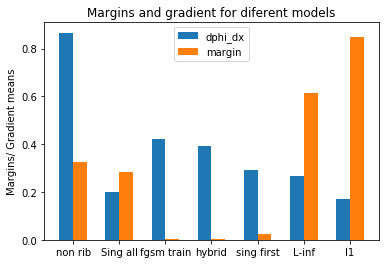

[0.0579 0.1185 0.8478 0.362  0.3424 0.3432 0.3325]


In [104]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Margins/ Gradient means')
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(adv_evals_np[:, 1])

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gradient means')
ax.set_ylim((0, 1.1))
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


color = 'tab:orange'
ax2 = ax.twinx()
rects2 = ax2.bar(x + width/2, margins, width, label='margin', color = color)
ax2.set_ylabel('Margins')
ax2.set_ylim((0, 0.40))
#ax.set_xticks(x)
#ax.set_xticklabels(labels)
#ax2.legend(legend_loc = (1.0, 0.8))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for (idx, rect) in enumerate(rects1):
        height = rect.get_height()
        height_2 = rects2[idx].get_height() * (1.0/0.37)
        height = max(height, height_2)
        ax.annotate('{:0.3f}'.format(acc_adv[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()
print(adv_evals_np[:, 1])

## Accuracies 

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = False)

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = True)

## Black box accuracies

In [105]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
angle_list = [10, 15, 20, 25, 30, 35, 40]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

Model was evaluated on benign data
I0920 10:39:51.316569 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:51.364467 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:51.541680 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:51.563088 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:55.052464 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:55.109900 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:55.237840 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:39:55.267482 4392146368 feedforward_robust.py:

I0920 10:40:29.323109 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:31.731184 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:31.762475 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:31.804378 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:31.839277 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:34.348951 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:34.370771 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:40:34.410632 4392146368 feedforward_robust.py:356] Model was evaluated on benign 

Model was evaluated on benign data
I0920 10:41:06.211216 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:41:08.431194 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:41:08.455984 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:41:08.476783 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:41:08.498052 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:41:10.713851 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:41:10.735856 4392146368 feedforward_robust.py:356] Model was evaluated on benign data
Model was evaluated on benign data
I0920 10:41:10.756645 4392146368 feedforward_robust.py:

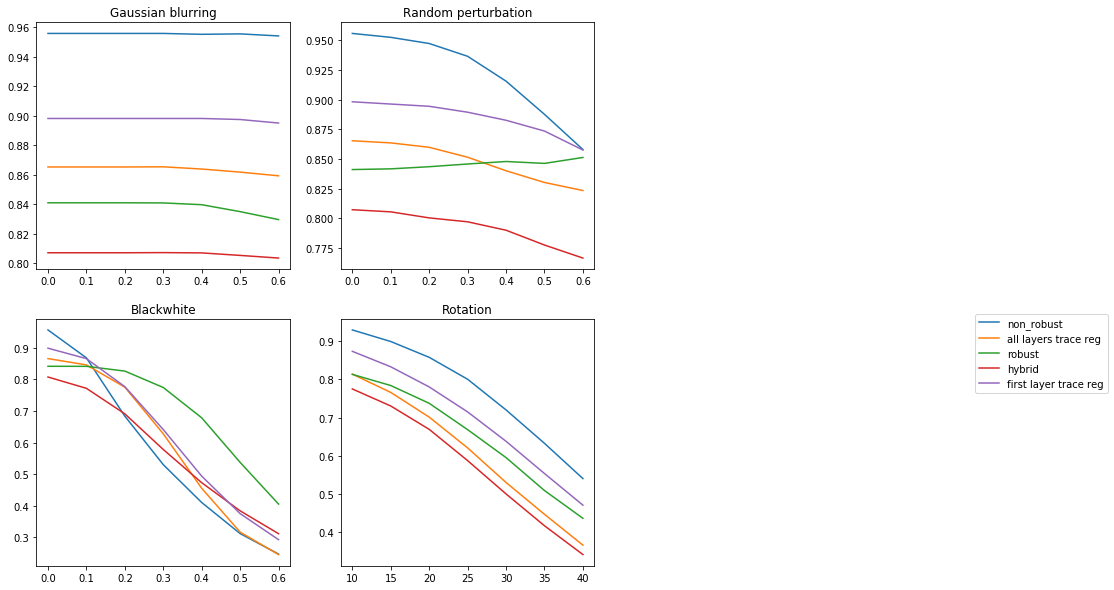

True

In [106]:
make_plot_acc_vs_eps_black_box(model_list, sess_list, eps_list, angle_list, legend_list, scope_list)

## Singular Values 

In [ ]:
norm_factor_non = sing_vals[0][0]
sing_non = sing_vals[0]/norm_factor_non
norm_factor_rob = sing_vals_robust[0][0]
sing_rob = sing_vals_robust[0]/norm_factor_rob

plt.loglog(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.loglog(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.semilogy(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.semilogy(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.plot(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.plot(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
def all_plots_layer_k(k):
    norm_factor_non = sing_vals[k][0]
    print("-----NORM FACTOR NON---")
    print(norm_factor_non)
    sing_non = sing_vals[k]/norm_factor_non
    norm_factor_rob = sing_vals_robust[k][0]
    print("-----NORM FACTOR ROB---")
    print(norm_factor_rob)
    sing_rob = sing_vals_robust[k]/norm_factor_rob
    plt.loglog(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.loglog(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.semilogy(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.semilogy(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.plot(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()

In [ ]:
num_layers = len(sing_vals)

In [ ]:
num_layers

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")